In [49]:
%matplotlib inline

import sys
from pathlib import Path

import random

import numpy as np

import re

import pandas as pd
from tqdm import tqdm


import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import scipy.stats

import krippendorff


random.seed(675756)
np.random.seed(675756)

base_path = Path("/nfs/users/tangxiangru/crowdsourcing/")
sys.path.append(str(base_path/"scripts"))

import summaryanalysis.ordinal as ordinal
from summaryanalysis.timereliability import compute_time_reliability_curve, compute_grouped_subsample_variance
from summaryanalysis.shr import compute_annotator_shr
from summaryanalysis.art import paired_approximate_randomization_test
from summaryanalysis.montecarlo import run_art_experiment, filter_wrong_rankings, read_obspower_files, run_art_experiment_fixed_budget, get_model_type1_error_rates


data_path = base_path/"final_result"

## First we load annotation in final_result file

In [50]:
experiments = {}
times = {}

for method in "likert", "bws":
    for question in "xsum", "cnndm":
        fname = f"{question}.{method}.csv"
        experiments[method, question] = pd.read_csv(data_path / fname, index_col=[0, 1, 2]).iloc[:,0:2]


## We reproduce the score distribution
For significance analysis, run analyse-ordinal.r

In [51]:
order = [
    ("likert", "xsum"),
    ("bws", "xsum"),
    ("likert", "cnndm"),
    ("bws", "cnndm")
]

system_order = ["pegasus", "prophetnet", "bart", "bertextabs"]

all_mean_scores = {}
for (method, question), judgements in experiments.items():
    mean_scores = judgements.groupby("system").mean()
    #print(mean_scores)
    if method == "bws":
        mean_scores += 1 # We export 0-based ranks, but 1-based ranks are more readable

    all_mean_scores[method, question] = mean_scores
    
headers = []
for (method, question) in order:
    headers.append(f"{method} - {question}")

rows = []
for system in system_order:
    row = []
    for (method, question) in order:
        mean_scores = all_mean_scores[method, question]
        #print(mean_scores)
        row.append(f"{mean_scores.loc[system].item():.3f}")
    rows.append(row)

print("\t".join(headers))
print("\n".join(map(lambda r: "\t".join(r), rows)))


likert - xsum	bws - xsum	likert - cnndm	bws - cnndm
3.350	3.247	3.887	3.230
3.293	3.360	3.860	3.100
3.433	3.570	4.017	3.593
2.790	2.827	3.863	3.087


## Compute krippendorff reliability

In [52]:
agreement_reliabilities = {}


for (method, question), judgements in experiments.items():
    if "likert_10" in method:
        key = "score"
    else:
        key = "score" if method == "likert" else "rank"
    annotation_matrix = pd.pivot_table(data=judgements.reset_index(), values=key, index=["document", "system"], columns="annotator")    
    agreement = krippendorff.alpha(annotation_matrix.T.to_numpy(), level_of_measurement="ordinal")
    agreement_reliabilities[method, question] = agreement

for (method, question), score in agreement_reliabilities.items():
    print(f"{method} {question} {score:.4f}")

likert xsum 0.2202
likert cnndm 0.0443
bws xsum 0.2477
bws cnndm 0.1582


## Compute SHR

In [53]:
for (method, question), judgements in experiments.items():
    if "likert_10" in method:
        key = "score"
    else:
        key = "score" if method == "likert" else "rank"
    print(question)
    print(method)
    shr = compute_annotator_shr(judgements, score_names=[key])
    shr = shr["pearson"].get(key)
    print(method, question, f"{shr:.5f}")

xsum
likert
likert xsum 0.92843
cnndm
likert
likert cnndm 0.44231
xsum
bws
bws xsum 0.90664
cnndm
bws
bws cnndm 0.87511


## Score distribution

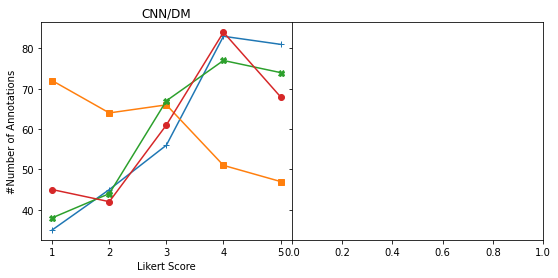

In [40]:
_, axes = plt.subplots(1, 2, sharey=True)

markers = {
    "pegasus": "X",
    "prophetnet": "o",
    "bart": "+",
    "bertextabs": "s",
}

labels = {
    "pegasus": "pegasus",
    "prophetnet": "prophetnet",
    "bart": "bart",
    "bertextabs": "bertextabs",
}

likert_experiments = list(filter(lambda x: x[0][0] == "likert", sorted(experiments.items())))

for idx, (ax, ((method, question), annotations)) in enumerate(zip(axes, likert_experiments)):
    all_val_counts = annotations.groupby(["system", "score"]).size()
    
    systems = sorted(all_val_counts.index.unique("system"))
    for system in systems:
        val_counts = all_val_counts.xs(system, level="system")
        ax.plot(val_counts.index.to_frame()["score"], val_counts, marker=markers[system], label=labels[system])
    
    if idx == 1:
        ax.set_title("XSum")
        plt.legend()
    else:
        ax.set_ylabel("#Number of Annotations")
        ax.set_title("CNN/DM")
    ax.set_xlabel("Likert Score")
        
fig = plt.gcf()
fig.subplots_adjust(hspace=0, wspace=0)
fig.set_size_inches(9, 4)
fig.savefig('scoredist.png', dpi=100, bbox_inches="tight")